In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from PIL import Image
import sys

In [2]:
#select the mode of panoptic
#set the path of picture/mask/label
panoptic_mode = int(input("Select the mode of panoptic: 1 for DETR, 2 for SETR: "))
if panoptic_mode == 1:
    Filepath = './DETR_result/'
    image1 = cv2.imread('image1.jpg')
    image2 = cv2.imread('image2.jpg')
    mask_label_path1 = Filepath + 'image1/'
    mask_label_path2 = Filepath + 'image2/'
    
elif panoptic_mode == 2:
    Filepath = './SETR_result/'
    image1 = cv2.imread('image1.jpg')
    image2 = cv2.imread('image2.jpg')
    mask_label_path1 = Filepath + 'image1/'
    mask_label_path2 = Filepath + 'image2/'

Select the mode of panoptic: 1 for DETR, 2 for SETR:  1


In [3]:
# create a dictionary to store the mask and label and category
def read_masks_and_labels(mask_label_path):
    labels = []
    categories = []

    with open(mask_label_path + 'image_categories.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split(',')
            label = parts[0].split(':')[1].strip()
            category = parts[1].split(':')[1].strip()
            labels.append(int(label))
            categories.append(category)

    masks = []
    mask_dict = {}
    
    for i, ID in enumerate (labels):
        filename = 'mask_class_' + str(ID) + '.png'
        mask = cv2.imread(mask_label_path + filename, cv2.IMREAD_GRAYSCALE)
        masks = np.array(mask)
        mask_dict[i] = {'labels': labels[i], 'categories': categories[i], 'masks': masks}
        
    return mask_dict

# Use the function to read masks and labels
mask_dict1 = read_masks_and_labels(mask_label_path1)
mask_dict2 = read_masks_and_labels(mask_label_path2)

In [4]:
def get_id_from_dict(mask_dict):
    ids = set()
    for i in range(len(mask_dict)):
        ids.add(mask_dict[i]['labels'])
    return ids

def sum_of_dif(modified_dict):
    if len(modified_dict) > 0:
        for i in range(len(modified_dict)):
            if i == 0:
                mask = modified_dict[i]['masks']
            # Update modified_dict with the new information
            else:
                mask = np.logical_or(mask, modified_dict[i]['masks']).astype(np.uint8)
    else:
        mask = np.zeros([10,10], dtype=np.uint8) 
    
    modified_dict = {
       'labels': 0,  # Assume 'labels' remains unchanged
        'categories': 'dismatch',
        'masks': mask
    }
    return modified_dict

def modified_dict_by_class_dif(mask_dict1, mask_dict2):
    # Create sets to store the IDs of each dictionary
    ids_dict1 = get_id_from_dict(mask_dict1)
    ids_dict2 = get_id_from_dict(mask_dict2)

    # print(ids_dict1)
    # print(ids_dict2)
    
    # Create dictionaries to store matched and unmatched items
    dif_dict1 = {}
    dif_dict2 = {}
    counter1 = 0
    counter2 = 0
    
    # Process the first dictionary
    for key in mask_dict1:
        if mask_dict1[key]['labels'] not in ids_dict2:
            dif_dict1[counter1] = mask_dict1[key]
            counter1+=1
    
    # Process the second dictionary
    for key in mask_dict2:
        if mask_dict2[key]['labels'] not in ids_dict1:
            dif_dict2[counter2] = mask_dict2[key]
            counter2+=1

    dif_modified_dict1 = {}
    dif_modified_dict2 = {}
    
    dif_modified_dict1 = sum_of_dif(dif_dict1)
    dif_modified_dict2 = sum_of_dif(dif_dict2)
    
    return dif_modified_dict1, dif_modified_dict2

dif_modified_dict1, dif_modified_dict2 = modified_dict_by_class_dif(mask_dict1, mask_dict2)

[[ 6.47289063e-01  1.09398204e-02  1.19005325e+03]
 [-2.45172143e-01  9.14543683e-01  1.45369579e+02]
 [-1.44495926e-04  3.44534677e-06  1.00000000e+00]]


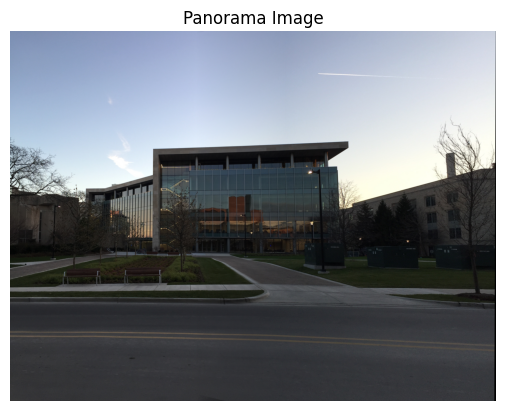

Panorama created successfully!
CPU times: user 19.6 s, sys: 2.45 s, total: 22.1 s
Wall time: 7.03 s


In [7]:
%%time

class Image_Stitching():
    def __init__(self):
        self.ratio = 0.85
        self.min_match = 10
        self.sift = cv2.SIFT_create()
        if mask_label_path1 == os.path.join(Filepath, 'image1/') and mask_label_path2 == os.path.join(Filepath, 'image2/'):
            self.smoothing_window_size = 800
        if mask_label_path1 == os.path.join(Filepath, 'image01/') and mask_label_path2 == os.path.join(Filepath, 'image02/'):
            self.smoothing_window_size = 300
        if mask_label_path1 == os.path.join(Filepath, 'image001/') and mask_label_path2 == os.path.join(Filepath, 'image002/'):
            self.smoothing_window_size = 250

    def registration(self, img1, img2):
        # Convert images to grayscale
        gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        
        # Detect keypoints and compute descriptors
        mask_1 = cv2.bitwise_not(dif_modified_dict1['masks'])
        mask_1 = cv2.resize(mask_1, (img1.shape[1], img1.shape[0]))
        mask_2 = cv2.bitwise_not(dif_modified_dict2['masks'])
        mask_2 = cv2.resize(mask_2, (img2.shape[1], img2.shape[0]))

        kp1, des1 = self.sift.detectAndCompute(gray_img1, mask_1)
        kp2, des2 = self.sift.detectAndCompute(gray_img2, mask_2)
        
        matcher = cv2.BFMatcher()
        raw_matches = matcher.knnMatch(des1, des2, k=2)
        good_points = []
        good_matches = []
        
        for m1, m2 in raw_matches:
            if m1.distance < self.ratio * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])
        
        img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
        
        if len(good_points) > self.min_match:
            image1_kp = np.float32(
                [kp1[i].pt for (_, i) in good_points])
            image2_kp = np.float32(
                [kp2[i].pt for (i, _) in good_points])
            H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC, 5.0)
            print(H)
            return H
        else:
            raise AssertionError("Can't find enough keypoints.")

    def create_mask(self, img1, img2, version):
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 + width_img2
        offset = int(self.smoothing_window_size / 2)
        barrier = img1.shape[1] - int(self.smoothing_window_size / 2)
        mask = np.zeros((height_panorama, width_panorama))
        if version == 'left_image':
            mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(1, 0, 2 * offset).T, (height_panorama, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(0, 1, 2 * offset).T, (height_panorama, 1))
            mask[:, barrier + offset:] = 1
        return cv2.merge([mask, mask, mask])

    def blending(self, img1, img2):
        H = self.registration(img1, img2)
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 + width_img2

        panorama1 = np.zeros((height_panorama, width_panorama, 3))
        mask1 = self.create_mask(img1, img2, version='left_image')
        panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
        panorama1 *= mask1
        mask2 = self.create_mask(img1, img2, version='right_image')
        panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama)) * mask2
        result = panorama1 + panorama2

        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :]

        return final_result.astype(np.uint8)  # Ensure the data type is uint8

def main(img1, img2):
    final = Image_Stitching().blending(img1, img2)

    # Display the panorama using matplotlib
    final_rgb = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(final_rgb)
    plt.title('Panorama Image')
    plt.axis('off')
    plt.show()

# Example usage
try:
    main(image1, image2)
    print("Panorama created successfully!")
except IndexError:
    print("Please input two source images.")
